<a href="https://colab.research.google.com/github/jhChoi1997/EE488_AI_Convergence_Capstone_Design_Anomaly_Detection_2022spring/blob/main/Experiment1/Assignment_1_Reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **EE 488 AI Convergence Capstone Design : Anomaly Detection**
## **Assignment 1 (Reconstruction)**


In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, TensorDataset
from sklearn import metrics
import matplotlib.pyplot as plt
import torchsummary
import torch.backends.cudnn
import numpy as np

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [3]:
LATENT_DIM = 32
EPOCHS = 1000
BATCH = 32
ANOMALY_NUM = 9

In [4]:
mnist_train = datasets.MNIST(root='MNIST_data/', train=True, transform=ToTensor(), download=True)
mnist_test = datasets.MNIST(root='MNIST_data/', train=False, transform=ToTensor(), download=True)

train_normal = [mnist_train[i][0].numpy() for i, v in enumerate(mnist_train) if v[1] != ANOMALY_NUM]

train_dataset = torch.Tensor(train_normal)

unseen_x = torch.tensor([v[0].numpy() for v in mnist_test])
unseen_y = torch.tensor([0 if v[1] != ANOMALY_NUM else 1 for v in mnist_test])

val_x = unseen_x[:int(len(unseen_x) / 2)]
val_y = unseen_y[:int(len(unseen_y) / 2)]

test_x = unseen_x[int(len(unseen_x) / 2):]
test_y = unseen_y[int(len(unseen_y) / 2):]

val_dataset = TensorDataset(val_x, val_y)
test_dataset = TensorDataset(test_x, test_y)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


In [5]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

54051
5000
5000


Complete the below code.

Model structure

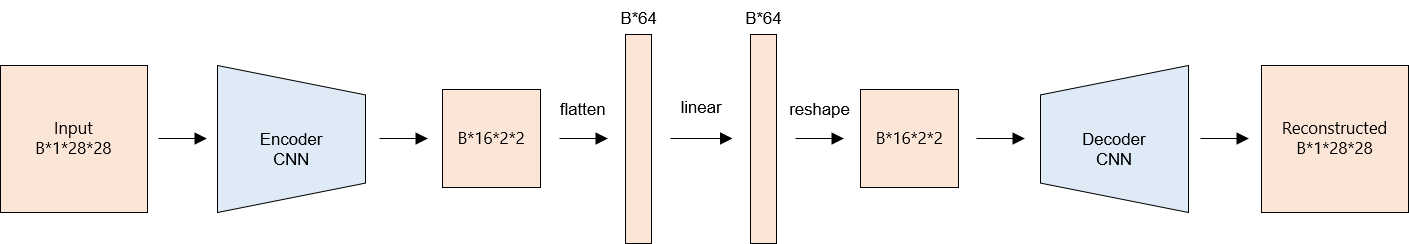

Encoder CNN

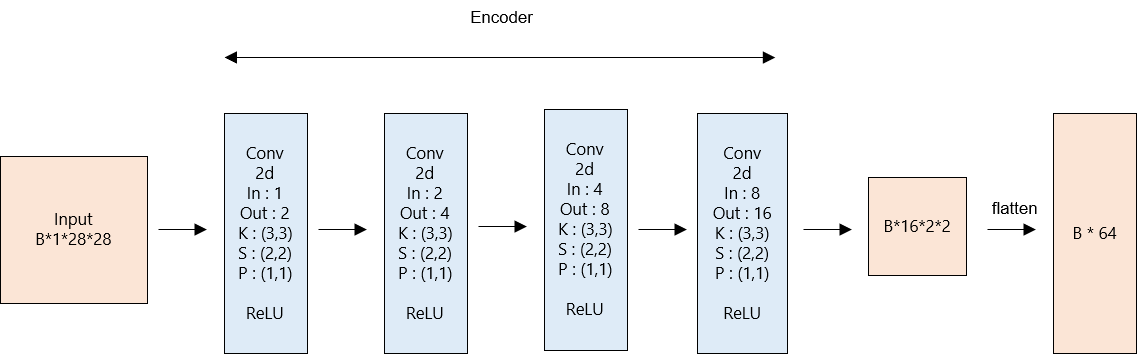

Linear

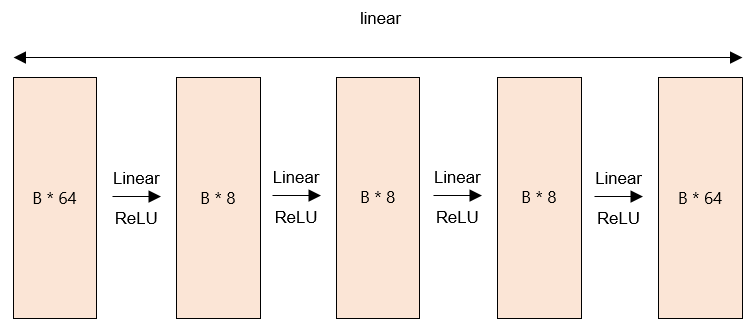

Decoder CNN

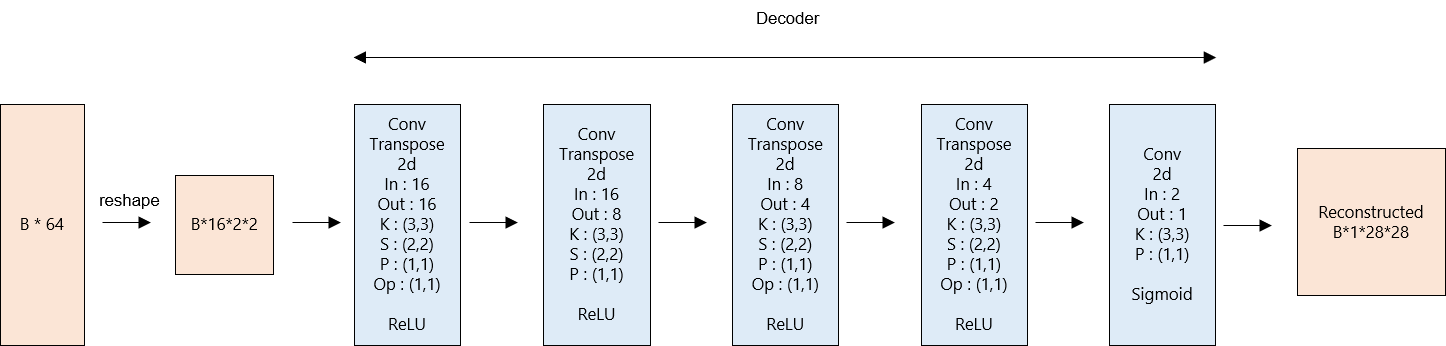

In [ ]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            # Build encoder (+1pts)
            # =================================================================





            # =================================================================
            nn.ReLU())
        self.linear = nn.Sequential(
            # Build linear (+0.5pts)
            # =================================================================





            # =================================================================
        )
        self.decoder = nn.Sequential(
            # Build decoder (+1pts)
            # =================================================================





            # =================================================================
        )

    def forward(self, x):
            # Complete forward (+0.5pts)
            # =================================================================





            # =================================================================
        return output

In [ ]:
model = ConvAutoEncoder().to(device)
print(model)

NameError: ignored

In [ ]:
loss_fn = nn.MSELoss()
anomaly_score = nn.MSELoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    losses = []
    for batch, X in enumerate(dataloader):
        X = X.to(device)

        pred = model(X)
        loss = loss_fn(pred, X)

        for idata in range(pred.shape[0]):

            iloss = loss_fn(pred[idata,:,:], X[idata,:,:])
            losses.append(iloss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 300 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    losses = [i.item() for i in losses]
    return np.mean(losses)

In [ ]:
def test(dataloader, model, loss_fn, anomaly_score, draw_mode = False):
    model.eval()

    y_true, y_pred = [], []

    normal_loss = []
    anomaly_loss = []

    with torch.no_grad():
      
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            output = model(X)

            for idata in range(output.shape[0]):

                loss = loss_fn(output[idata,:,:], X[idata,:,:])
                if y[idata] == 0:
                    normal_loss.append(loss)
                elif y[idata] == 1:
                    anomaly_loss.append(loss)
            
            score = torch.mean(anomaly_score(X, output), (1, 2, 3))

            y_true.extend(y.tolist())
            y_pred.extend(score.tolist())

    roc_auc = metrics.roc_auc_score(y_true, y_pred)

    if draw_mode:
        fpr, tpr, _ = metrics.roc_curve(y_true,y_pred)
        plt.figure(figsize=(10,10))
        plt.plot(fpr,tpr)
        plt.title('ROC curve')
        plt.xlabel('FPR')
        plt.ylabel('TPR')


    print(f'AUC: {roc_auc:>0.3f}')
    normal_loss = [i.item() for i in normal_loss]
    anomaly_loss = [i.item() for i in anomaly_loss]
    normal_loss_mean = np.mean(normal_loss)
    anomaly_loss_mean = np.mean(anomaly_loss)
    print(f'normal loss : {normal_loss_mean}')
    print(f'anomaly loss : {anomaly_loss_mean}')
    return roc_auc.item(), normal_loss_mean, anomaly_loss_mean

In [ ]:
aucs = []
train_normal_losses = []
val_normal_losses = []
val_anomaly_losses = []
best_auc = 0
best_model = model.to(device)
for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train_normal_loss = train(train_dataloader, model, loss_fn, optimizer)
    auc, val_normal_loss, val_anomaly_loss = test(val_dataloader, model, loss_fn, anomaly_score)
    train_normal_losses.append(train_normal_loss)
    aucs.append(auc)
    val_normal_losses.append(val_normal_loss)
    val_anomaly_losses.append(val_anomaly_loss)
    if best_auc < auc:
      best_model = model
      best_auc = auc

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
loss: 0.030798  [28800/48646]
loss: 0.030544  [38400/48646]
loss: 0.024255  [48000/48646]
AUC: 0.614
normal loss : 0.02798488036278286
anomaly loss : 0.0338726770831272
Epoch 547
-------------------------------
loss: 0.028922  [    0/48646]
loss: 0.028398  [ 9600/48646]
loss: 0.026964  [19200/48646]
loss: 0.030514  [28800/48646]
loss: 0.032017  [38400/48646]
loss: 0.023906  [48000/48646]
AUC: 0.616
normal loss : 0.028125115992900518
anomaly loss : 0.03416582117609393
Epoch 548
-------------------------------
loss: 0.028531  [    0/48646]
loss: 0.028031  [ 9600/48646]
loss: 0.026929  [19200/48646]
loss: 0.029535  [28800/48646]
loss: 0.030752  [38400/48646]
loss: 0.024077  [48000/48646]
AUC: 0.623
normal loss : 0.028067453654797906
anomaly loss : 0.035100158026370294
Epoch 549
-------------------------------
loss: 0.029154  [    0/48646]
loss: 0.028209  [ 9600/48646]
loss: 0.027272  [19200/48646]
loss: 0.028814  [28800/48646]
loss: 0.030579  [38400/486

<Figure size 432x288 with 0 Axes>

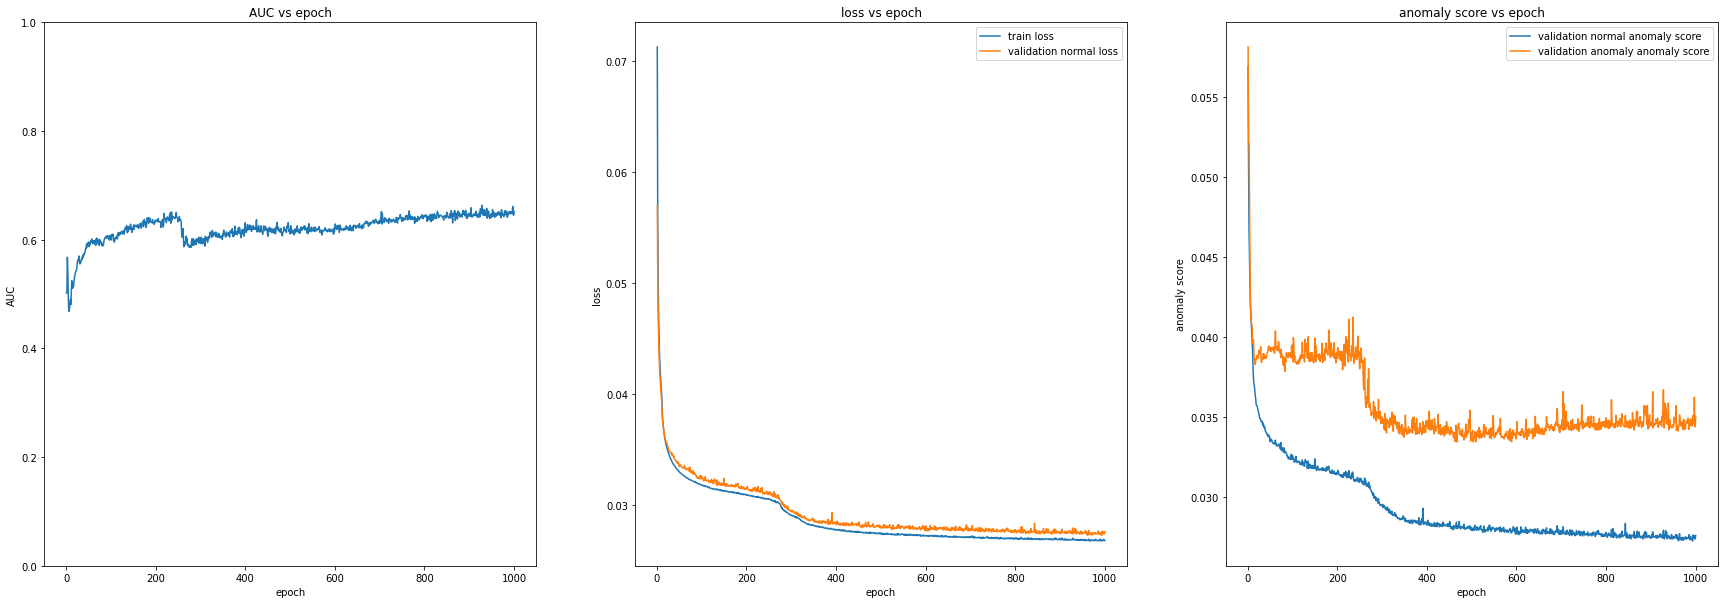

In [ ]:
plt.clf()
plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plt.plot(list(range(1,len(aucs)+1)),aucs)
plt.xlabel('epoch')
plt.ylabel('AUC')
plt.title('AUC vs epoch')
plt.ylim([0, 1])

plt.subplot(1,3,2)
plt.plot(list(range(1,len(train_normal_losses)+1)),train_normal_losses)
plt.plot(list(range(1,len(val_normal_losses)+1)),val_normal_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss vs epoch')
plt.legend(['train loss', 'validation normal loss'])

plt.subplot(1,3,3)
plt.plot(list(range(1,len(val_normal_losses)+1)),val_normal_losses)
plt.plot(list(range(1,len(val_anomaly_losses)+1)),val_anomaly_losses)
plt.xlabel('epoch')
plt.ylabel('anomaly score')
plt.title('anomaly score vs epoch')
plt.legend(['validation normal anomaly score','validation anomaly anomaly score'])

AUC: 0.715
normal loss : 0.0261708021802044
anomaly loss : 0.03549916096839193


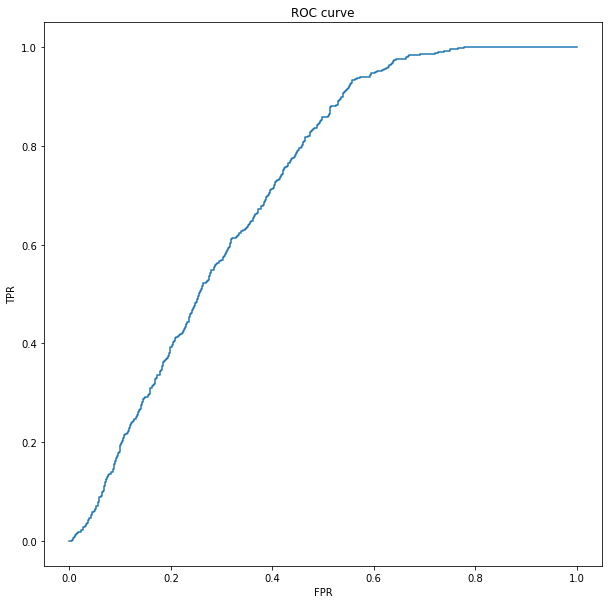

In [ ]:
auc, _, _ = test(test_dataloader, best_model, loss_fn, anomaly_score, True)

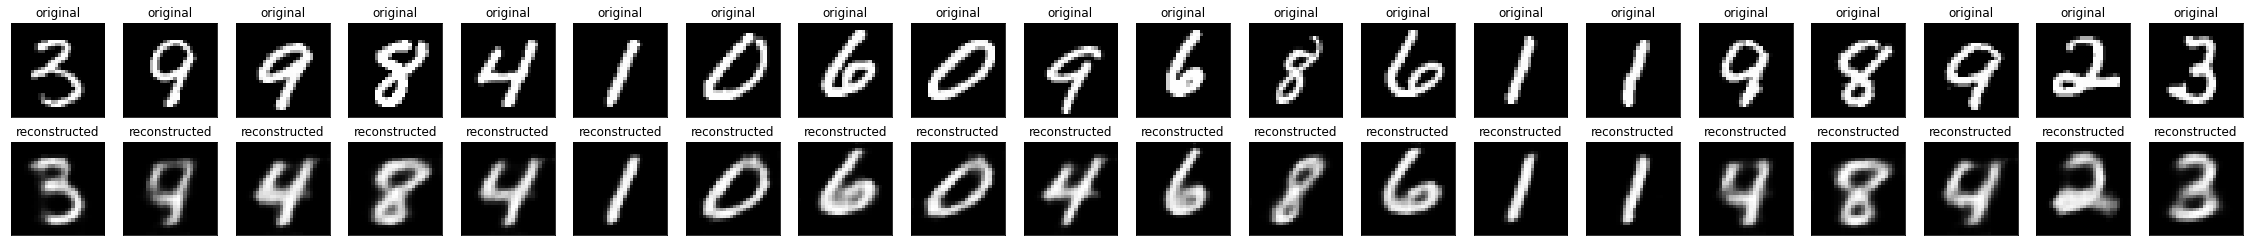

In [ ]:
n = 20
plt.figure(figsize=(2*n, 4))

for i in range(n):
  input_image = test_dataset[i][0].to(device)
  output_image = best_model(input_image.unsqueeze(0))

  ax = plt.subplot(2, n, i + 1)
  plt.imshow(input_image[0].cpu())
  plt.title('original')
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(output_image[0].squeeze().detach().cpu())
  plt.title('reconstructed')
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()